In [1]:
%config Completer.use_jedi = False

In [2]:
import math
import numpy as np
import pandas as pd
from cmaes import CMA
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist

In [3]:
def errorfcn(alpha, Xbar, n, m):
    f1 = np.reshape(alpha[(2 * n):], (m, 2))
    f2 = np.reshape(alpha[0:2 * n], (2, n))
    f3 = Xbar[:, 0:n].T
    r = (Xbar - np.dot(f1, np.dot(f2, f3)).T) ** 2
    return np.nanmean(np.nanmean(r, axis=0))

In [4]:
import os

synthetic_datasets = os.listdir('../datasets/sklearn-datasets')
real_datasets = os.listdir('../datasets/real-datasets')

In [5]:
datasets_dictionary = dict()
for f in synthetic_datasets:
    try:
        df = pd.read_csv(f'../datasets/sklearn-datasets/{f}')
        target_columns = [col for col in df.columns if col.startswith('target')]
        datasets_dictionary[f] = (df, target_columns)
    except:
        pass

for f in real_datasets:
    try:
        df = pd.read_csv(f'../datasets/real-datasets/{f}').drop(columns = ['instances'])
        target_columns = [col for col in df.columns if col.startswith('algo')]
        datasets_dictionary[f] = (df, target_columns)
    except:
        pass

In [6]:
from dataclasses import dataclass

@dataclass
class OptimizationOutput:
    A: np.ndarray
    B: np.ndarray
    C: np.ndarray
    Z: np.ndarray
    error: float
    execution_time: float
    n_tries: int
    search_space: float
    method_name: str

In [7]:
import time

def bipop_cma_es(X, Y, **kwargs):
    np.random.seed(0)
    
    Xbar = np.hstack((X, Y))
    n = X.shape[1]
    m = Xbar.shape[1]

    if 'search_space' not in kwargs:
        search_space = 32.768
    else:
        search_space = kwargs['search_space']
        
    bounds = list()
    bounds.append([[-search_space, search_space] for i in range(2 * m + 2 * n)])
    bounds = np.array(bounds).reshape((2 * m + 2 * n, 2))

    lower_bounds, upper_bounds = bounds[:, 0], bounds[:, 1]
    mean = lower_bounds + (np.random.rand(2 * m + 2 * n) * (upper_bounds - lower_bounds))
    sigma = search_space * 2 / 5  # 1/5 of the domain width

    optimizer = CMA(mean=mean, sigma=sigma, bounds=bounds, seed=0)
    
    if 'ntries' not in kwargs:
        ntries = 100
    else:
        ntries = kwargs['ntries']

    perf = np.zeros(ntries)
    alpha = np.zeros((2 * m + 2 * n, ntries))
    Hd = pdist(X)[np.newaxis].T

    n_restarts = 30  # A small restart doesn't count in the n_restarts
    small_n_eval, large_n_eval = 0, 0
    popsize0 = optimizer.population_size
    inc_popsize = 2

    # Initial run is with "normal" population size; it is
    # the large population before first doubling, but its
    # budget accounting is the same as in case of small
    # population.
    poptype = "small"
    
    start_time = time.time()
    for generation in range(ntries):
        solutions = []
        for _ in range(optimizer.population_size):
            alpha[:, generation] = optimizer.ask()

            # Calculate function value
            value = errorfcn(alpha = alpha[:, generation], Xbar = Xbar, n = n, m = m)
            solutions.append((alpha[:, generation], value))
    #         print(f"#{generation} {value} (x1={x[0]}, x2 = {x[1]})")
        optimizer.tell(solutions)

        aux = alpha[:, [generation]]
        A = np.reshape(aux[0:2 * n], (2, n))
        Z = np.dot(X, A.T)
        perf[generation] = np.corrcoef(Hd, pdist(Z)[np.newaxis].T, rowvar=False)[0][1]

        if optimizer.should_stop():
            n_eval = optimizer.population_size * optimizer.generation
            if poptype == "small":
                small_n_eval += n_eval
            else:  # poptype == "large"
                large_n_eval += n_eval

            if small_n_eval < large_n_eval:
                poptype = "small"
                popsize_multiplier = inc_popsize ** n_restarts
                popsize = math.floor(
                    popsize0 * popsize_multiplier ** (np.random.uniform() ** 2)
                )
            else:
                poptype = "large"
                n_restarts += 1
                popsize = popsize0 * (inc_popsize ** n_restarts)

            mean = lower_bounds + (np.random.rand(2) * (upper_bounds - lower_bounds))
            optimizer = CMA(
                mean=mean,
                sigma=sigma,
                bounds=bounds,
                population_size=popsize,
            )
            print("Restart CMA-ES with popsize={} ({})".format(popsize, poptype))
    end_time = time.time()
    
    idx = np.argmax(perf)
    A = np.reshape(alpha[0:2 * n, idx], (2, n))
    Z = np.dot(X, A.T)
    B = np.reshape(alpha[(2 * n):, idx], (m, 2))
    Xhat = np.dot(Z, B.T)
    C = B[n:m + 1, :].T
    B = B[0:n + 1, :]
    error = np.sum((Xbar - Xhat) ** 2)
    execution_time = end_time - start_time
    
    out = OptimizationOutput(A, B, C, Z, error, execution_time, ntries, search_space, 'bipop')

    return out

In [8]:
from experimentation import run_optimization

In [9]:
df_teste = pd.read_csv('../datasets/real-datasets/XOR_metadata.csv').drop(columns = ['instances'])
performance_columns = [col for col in df.columns if col.startswith('algo')]

In [10]:
%%time
bipop_output = run_optimization(df_teste, performance_columns, bipop_cma_es, ntries = 5)

CPU times: user 678 ms, sys: 18.5 ms, total: 696 ms
Wall time: 468 ms


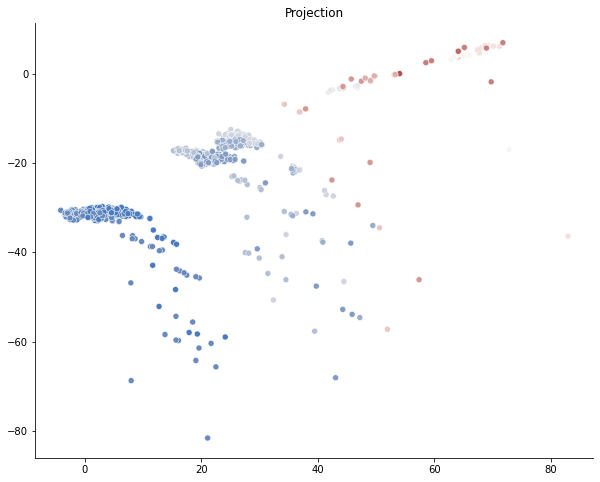

In [11]:
def plot_scatter_plot(x, y, title = None, x_label = None, y_label = None, hue_data = None):
    fig, ax = plt.subplots(figsize = (10, 8))
    n_colors = len(hue_data.unique())
    sns.scatterplot(x = x, y = y, hue = hue_data, palette = sns.color_palette("vlag", n_colors), legend = False)
    ax.set_title(title)
    sns.despine()
    
plot_scatter_plot(x = bipop_output.Z[:, 0], 
                  y = bipop_output.Z[:, 1], 
                  title = "Projection",
                  hue_data = df_teste.iloc[:,1],
                 )

In [12]:
%%time
n_tries = 30
search_space = 0.1
experiments = dict()
for filename, item in datasets_dictionary.items():
    experiments[filename] = run_optimization(df = item[0], 
                                             target_columns = item[1], 
                                             optimization_method = bipop_cma_es, 
                                             ntries = n_tries,
                                             search_space = search_space
                                            )

CPU times: user 13min 28s, sys: 12.2 s, total: 13min 41s
Wall time: 8min


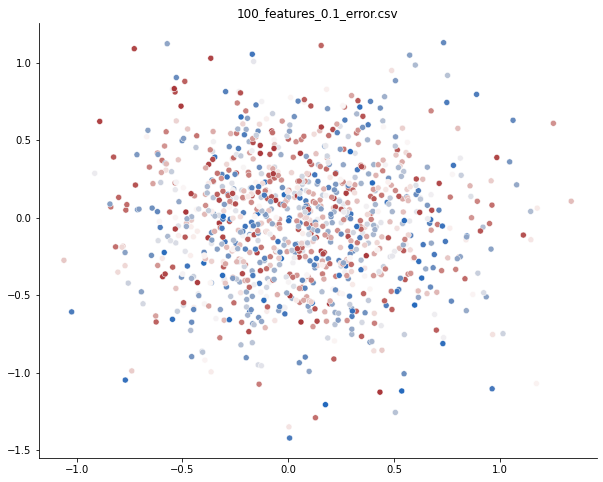

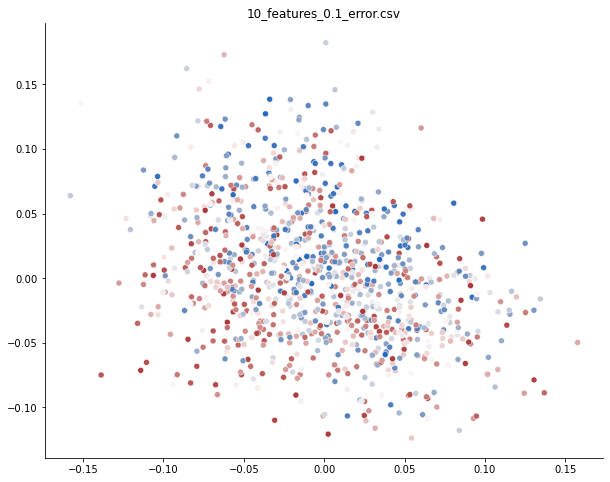

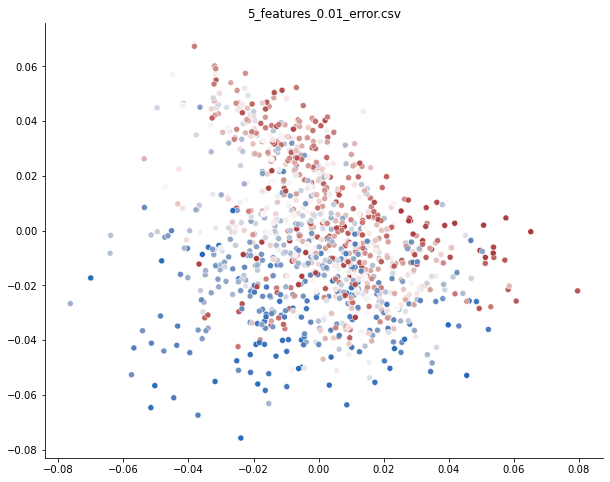

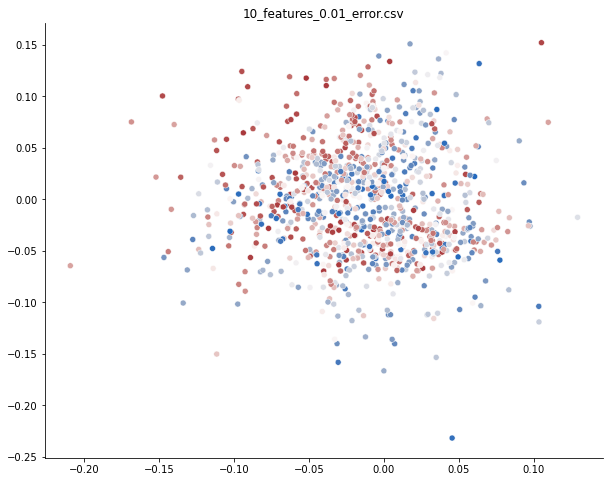

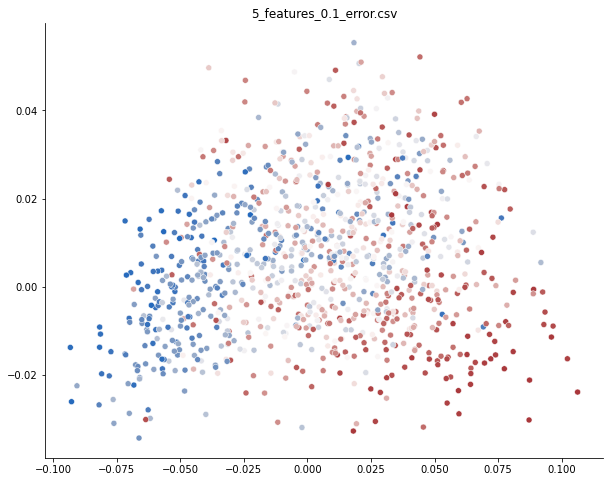

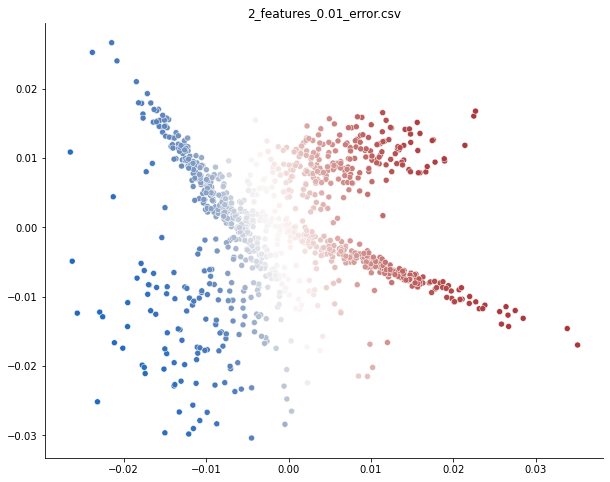

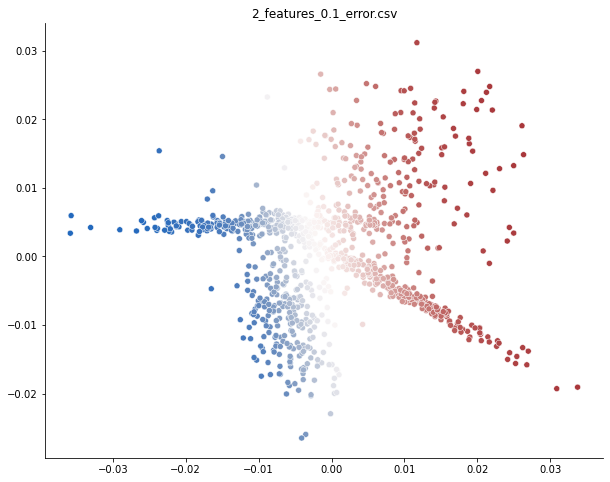

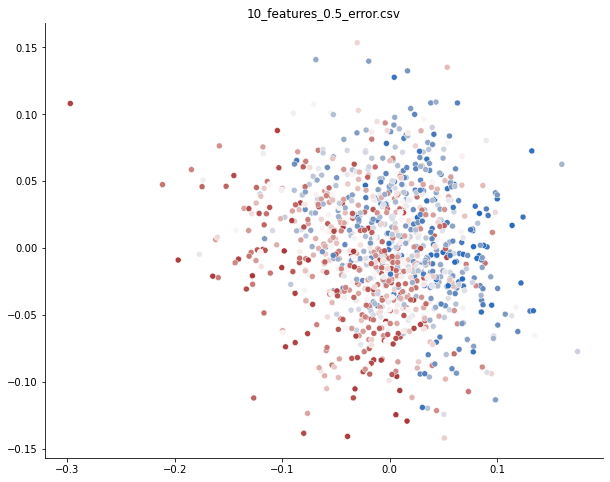

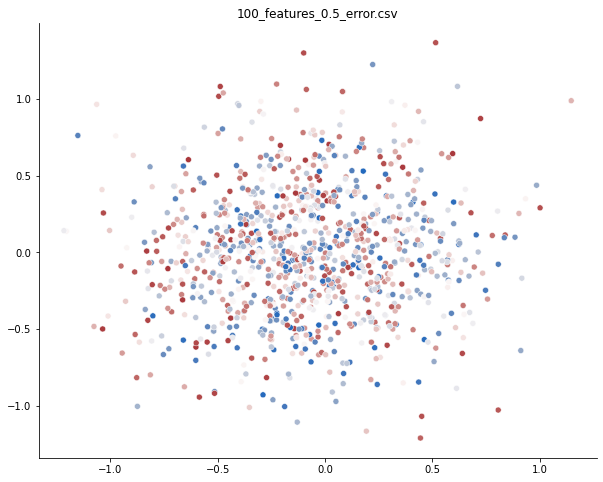

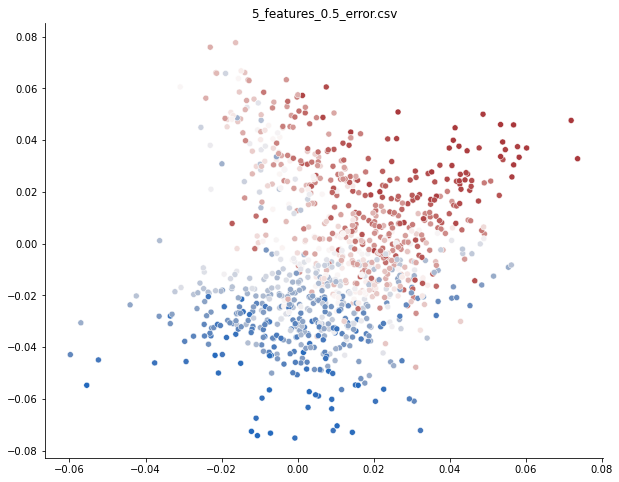

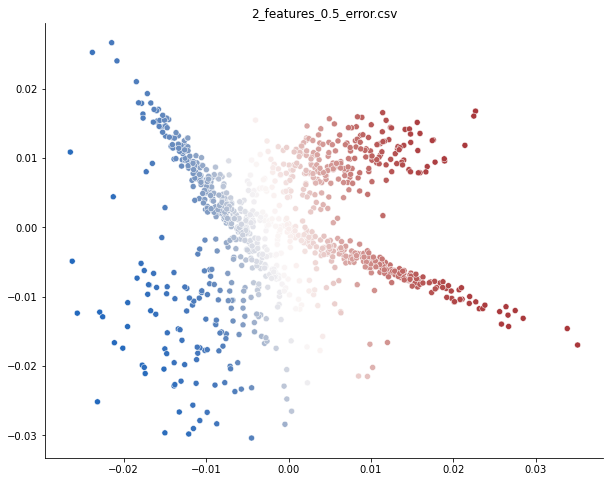

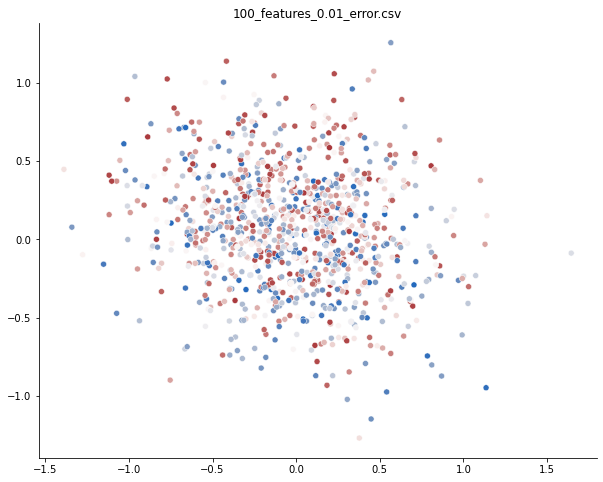

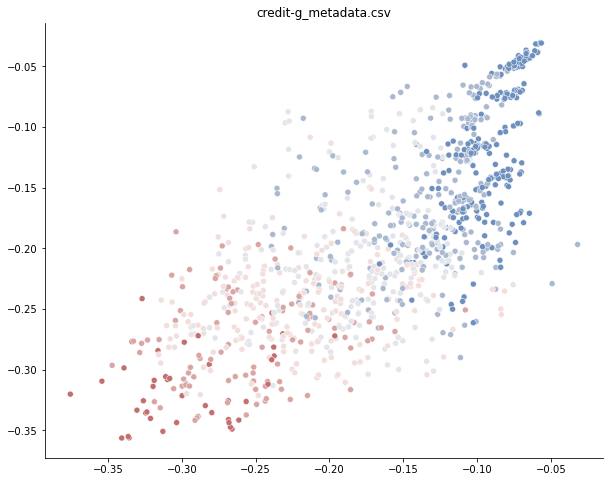

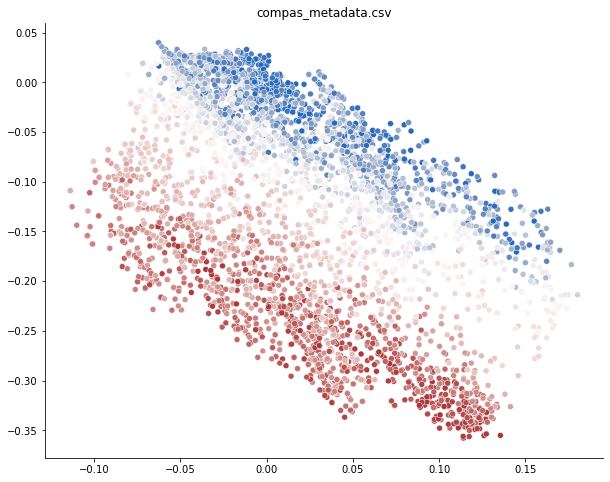

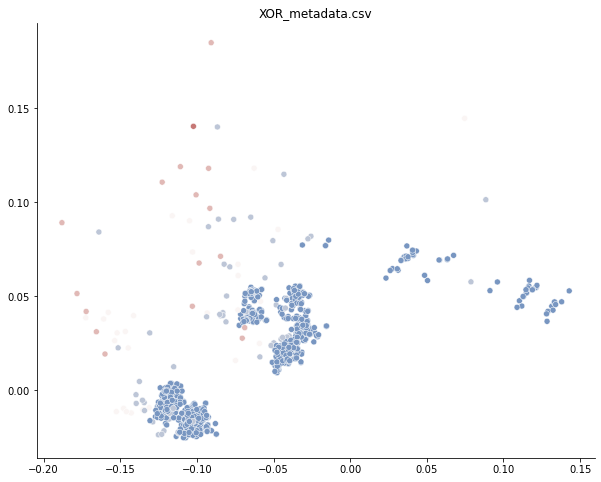

In [13]:
for dataset_filename in experiments.keys():
    plot_scatter_plot(x = experiments[dataset_filename].Z[:, 0],
                     y = experiments[dataset_filename].Z[:, 1],
                      hue_data = datasets_dictionary[dataset_filename][0].iloc[:, 0],
                     title = dataset_filename)

In [14]:
from experimentation import create_results_dataframe

bipop_results_df = create_results_dataframe(experiments)
bipop_results_df

,dataset,error,execution_time,method,n_tries,search_space
0,100_features_0.1_error.csv,35283.782523,153.818104,bipop,30,0.1
1,10_features_0.1_error.csv,944.029476,2.117284,bipop,30,0.1
2,5_features_0.01_error.csv,631.761232,1.105008,bipop,30,0.1
3,10_features_0.01_error.csv,943.882947,1.768929,bipop,30,0.1
4,5_features_0.1_error.csv,622.851254,1.094934,bipop,30,0.1
5,2_features_0.01_error.csv,539.197983,0.432470,bipop,30,0.1
6,2_features_0.1_error.csv,537.457253,0.708683,bipop,30,0.1
7,10_features_0.5_error.csv,938.181374,2.145537,bipop,30,0.1
8,100_features_0.5_error.csv,35290.055958,143.589973,bipop,30,0.1
9,5_features_0.5_error.csv,593.821884,1.326498,bipop,30,0.1


In [16]:
bipop_results_df.to_excel(f'../results/bipop-results-ntries{n_tries}-searchspace{search_space}.xlsx')